In [1]:
from pathlib import Path


DATA_dir = Path('../data/')
IMAGES_DIR = Path(DATA_dir / 'images/')

In [146]:
import pandas as pd
import math

trainset = pd.read_json(DATA_dir / "trainset.json")
testset = pd.read_json(DATA_dir / "testset.json")

target = 'HEAD'
trainset = trainset[trainset['image_organ'] == target]
testset = testset[testset['image_organ'] == target]

In [147]:
trainset

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,1,synpic54610.jpg,HEAD,Yes,CLOSED,PRES,Are regions of the brain infarcted?,freeform
8,9,synpic39460.jpg,HEAD,left temporal lobe,OPEN,POS,Where is the abnormality?,freeform
11,15,synpic54610.jpg,HEAD,vasculature,OPEN,POS,Where is the pathology in this image?,freeform
13,17,synpic54610.jpg,HEAD,MRI Diffusion Weighted,OPEN,MODALITY,What type of imaging is this?,freeform
14,18,synpic54610.jpg,HEAD,the brain,OPEN,ORGAN,What organ system is pictured?,freeform
...,...,...,...,...,...,...,...,...
3049,3501,synpic53816.jpg,HEAD,No,CLOSED,PRES,Is there midline shift?,frame
3056,3508,synpic56841.jpg,HEAD,FLAIR,CLOSED,MODALITY,"Is this a T1 weighted, T2 weighted, or FLAIR i...",freeform
3057,3509,synpic56841.jpg,HEAD,FLAIR,CLOSED,MODALITY,What is/are the image weighting of the MRI?,frame
3058,3510,synpic56841.jpg,HEAD,FLAIR,CLOSED,MODALITY,"Is this image modality T1, T2, or FLAIR?",para


In [148]:
testset

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
2,14,synpic54610.jpg,HEAD,yes,CLOSED,PLANE,Is this an axial plane?,freeform
4,22,synpic54610.jpg,HEAD,yes,CLOSED,ABN,Is there vascular pathology in this image?,freeform
56,427,synpic57368.jpg,HEAD,Ring-enhancing lesions,OPEN,ATTRIB,How would you describe the abnormalities,freeform
57,429,synpic57368.jpg,HEAD,Yes,CLOSED,"ATTRIB, PRES",Are the lesions ring-enhancing?,para
58,431,synpic56799.jpg,HEAD,right temporal lobe,OPEN,POS,What lobe is the lesion located in?,para
...,...,...,...,...,...,...,...,...
437,3026,synpic31116.jpg,HEAD,MRI,CLOSED,MODALITY,Is this a CT or an MRI?,freeform
438,3027,synpic31116.jpg,HEAD,MRI,CLOSED,MODALITY,Was a CT or MRI used to take the above image?,para
439,3030,synpic42951.jpg,HEAD,axial,OPEN,PLANE,This image is taken in what plane?,freeform
440,3055,synpic31928.jpg,HEAD,no,CLOSED,SIZE,Are the ventricles an abnormal size?,freeform


In [158]:
import re
import cv2
import matplotlib.pyplot as plt


def load_image(idx, source=trainset):
    item = source.iloc[idx]
    img = cv2.imread(str(IMAGES_DIR / item['image_name']), cv2.CV_8UC1)
    return img


def display_image(start, nrow=3, ncol=3, source=trainset):
    if not nrow or not ncol:
        raise ValueError('nrow and ncol must be positive integers')

    for i in range(nrow * ncol):
        item = source.iloc[start + i]
        img = cv2.imread(str(IMAGES_DIR / item['image_name']))
        id = ''.join(re.findall(r'\d+', item['image_name']))
        title = id + '\n' + item['question'] + '\n' + item['answer']
        scale = abs(nrow - 1) * 0.3, abs(ncol - 1) * 0.8

        plt.subplot(nrow, ncol, i+1)
        plt.subplots_adjust(hspace=scale[0], wspace=scale[1])
        plt.imshow(img)
        plt.title(title,fontsize=8)
        plt.xticks([])
        plt.yticks([])

    plt.show()

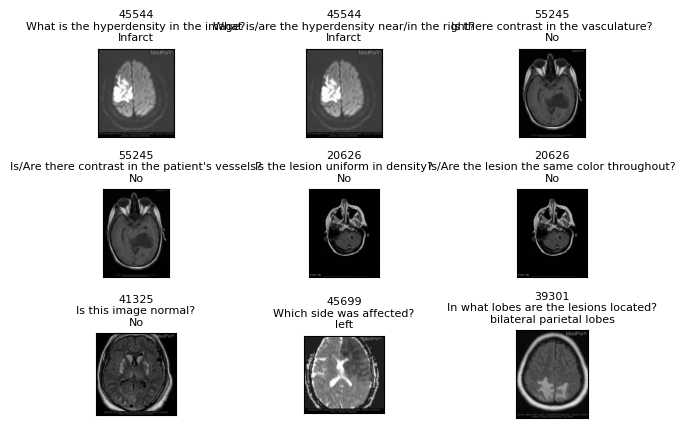

977
103


In [159]:
display_image(700)
print(len(trainset['image_name']))
print(len(trainset['image_name'].unique()))

### Image Preprocessing

In [189]:
import numpy as np
import scipy.stats as stats


def tilt(img):
    blur = cv2.GaussianBlur(img, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Dilate with elliptical shaped kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours, filter using contour threshold area, draw ellipse
    cnts = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area > 5000:
            ellipse = cv2.fitEllipse(c)
            cv2.ellipse(img, ellipse, (36,255,12), 2)

    plt.imshow(img)
    plt.show
    
    

def adjust_tilt(img):
    contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    # cv2.drawContours(img, contours, -1, (255, 0, 0), 3)

    # find the biggest contour (c) by the area
    c = max(contours, key=cv2.contourArea)

    (x, y), (a, b), angle = cv2.fitEllipse(c)

    cv2.ellipse(img, ((x, y), (a, b), angle), color=(0, 255, 0), thickness=2)

    rmajor = max(a, b) / 2

    if angle > 90:
        angle -= 90
    else:
        angle += 90

    xtop = x + math.cos(math.radians(angle)) * rmajor
    ytop = y + math.sin(math.radians(angle)) * rmajor
    xbot = x + math.cos(math.radians(angle + 180)) * rmajor
    ybot = y + math.sin(math.radians(angle + 180)) * rmajor
    cv2.line(img, (int(xtop), int(ytop)), (int(xbot), int(ybot)), (0, 255, 0),
             3)

    plt.imshow(img)
    plt.show()

    M = cv2.getRotationMatrix2D((x, y), angle - 90, 1)  # transformation matrix
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

    plt.imshow(img)
    plt.show()


def subimage(img):
    padding = int(img.shape[1]/25)
    img = cv2.copyMakeBorder(img, padding, padding, padding, padding,
    cv2.BORDER_CONSTANT, value=[255, 255, 255])

    # 轉換至 HSV 色彩空間
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_small = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 取出飽和度
    saturation = hsv[:,:,1]
    saturation_small = hsv_small[:,:,1]

    # 取出明度
    value = hsv[:,:,2]
    value_small = hsv_small[:,:,2]

    # 綜合飽和度與明度
    sv_ratio = 0.8
    sv_value = cv2.addWeighted(saturation, sv_ratio, value, 1-sv_ratio, 0)
    sv_value_small = cv2.addWeighted(saturation_small, sv_ratio, value_small, 1-sv_ratio, 0)

    # 使用 Kernel Density Estimator 計算出分佈函數
    density = stats.gaussian_kde(sv_value_small.ravel(), bw_method=0.2)

    # 找出 PDF 中第一個區域最小值（Local Minimum）作為門檻值
    step = 0.5
    xs = np.arange(0, 256, step)
    ys = density(xs)
    cum = 0
    for i in range(1, 250):
      cum += ys[i-1] * step
      if (cum > 0.02) and (ys[i] < ys[i+1]) and (ys[i] < ys[i-1]):
        threshold_value = xs[i]
        break
      
    _, threshold = cv2.threshold(sv_value, threshold_value, 255.0, cv2.THRESH_BINARY)

    # 去除微小的雜訊
    kernel_radius = int(img.shape[1]/100)
    kernel = np.ones((kernel_radius, kernel_radius), np.uint8)
    threshold = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel)
    threshold = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)

    # 產生等高線
    contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 建立除錯用影像
    img_debug = img.copy()

    # 線條寬度
    line_width = int(img.shape[1]/100)

    # 以藍色線條畫出所有的等高線
    cv2.drawContours(img_debug, contours, -1, (255, 0, 0), line_width)

    # 找出面積最大的等高線區域
    c = max(contours, key = cv2.contourArea)

    # 找出可以包住面積最大等高線區域的方框，並以綠色線條畫出來
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img_debug,(x, y), (x + w, y + h), (0, 255, 0), line_width)

    # 嘗試在各種角度，以最小的方框包住面積最大的等高線區域，以紅色線條標示
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_debug, [box], 0, (0, 0, 255), line_width)

    angle = rect[2]
    if angle < -45:
      angle = 90 + angle

    # 以影像中心為旋轉軸心
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)

    # 計算旋轉矩陣
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 旋轉圖片
    rotated = cv2.warpAffine(img_debug, M, (w, h),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
    img_final = cv2.warpAffine(img, M, (w, h),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)

    return rotated


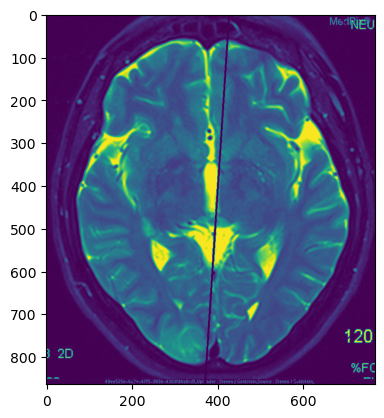

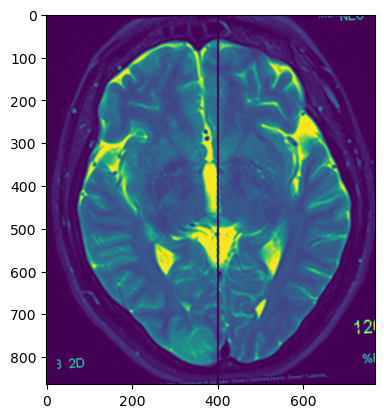

In [190]:
import random

n = random.randint(0, len(trainset))
item = trainset.iloc[n]
# img = cv2.imread(str(IMAGES_DIR / item['image_name']))
img = cv2.imread(str(IMAGES_DIR / 'synpic60831.jpg'), cv2.CV_8UC1)
adjust_tilt(img)

In [138]:
def hu_transform(img, ww, wl, dst_range=(0, 1)):
    src_min = wl - ww / 2
    src_max = wl + ww / 2
    outputs = (img - src_min) / ww * (dst_range[1] - dst_range[0]) + dst_range[0]
    outputs[img >= src_max] = 1
    outputs[img <= src_min] = 0

    outputs *= 255

    return outputs

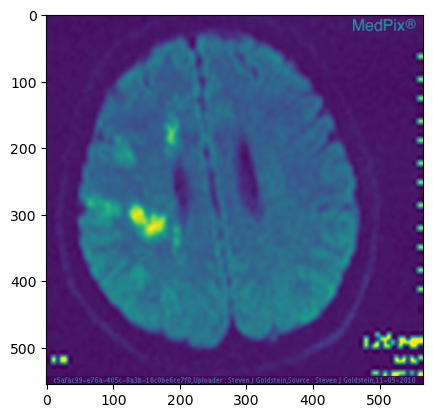

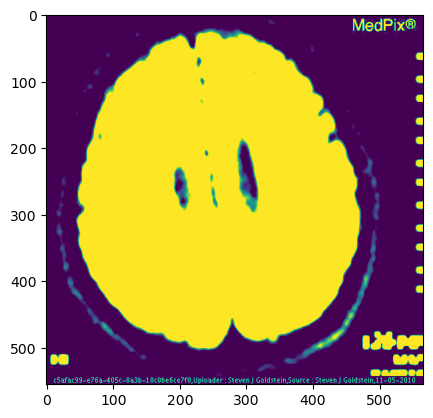

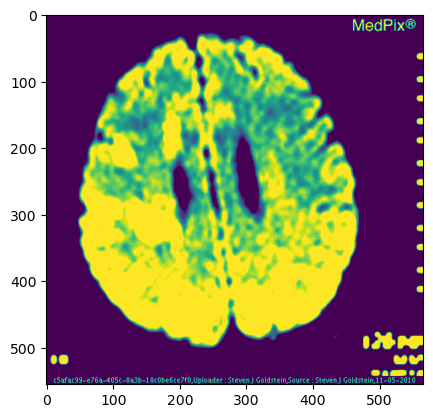

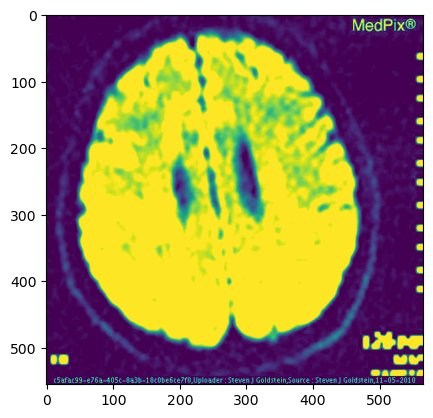

In [153]:
import random

n = random.randint(0, len(trainset))
n = 0

img = load_image(n)
plt.imshow(img)
plt.show()

output = hu_transform(img, 24, 34)
plt.imshow(output)
plt.show()

output = hu_transform(img, 48, 68)
plt.imshow(output)
plt.show()